In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.optimizers import SGD

In [11]:
# Log setting
import os
import logging
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

In [12]:
MACHINELEARNINGCSV = "MachineLearningCVE.csv"
TRAFFICLABELLING_PATH =  MACHINELEARNINGCSV
PROCESSED_DIR_PATH = "processed"
FILE_PATH = TRAFFICLABELLING_PATH

In [13]:
df = pd.read_csv(TRAFFICLABELLING_PATH)
df.shape


(2830743, 79)

In [14]:
#replace infinit number
df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

#drop null
df.dropna(how = 'all')

# Calculate label counts
label_counts = df['Label'].value_counts()
print(label_counts)

#this drops two columns for some reason
df.shape

BENIGN                      2273097
DoS Hulk                     231073
PortScan                     158930
DDoS                         128027
DoS GoldenEye                 10293
FTP-Patator                    7938
SSH-Patator                    5897
DoS slowloris                  5796
DoS Slowhttptest               5499
Bot                            1966
Web Attack-Brute Force         1507
Web Attack-XSS                  652
Infiltration                     36
Web Attack-Sql Injection         21
Heartbleed                       11
Name: Label, dtype: int64


(2830743, 77)

In [15]:
"""
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y_encoded)
path_to_save = 'models/random_forest_model.pkl'
dump(rf, path_to_save)
"""



"\nrf = RandomForestClassifier(n_estimators=100, random_state=42)\nrf.fit(X_scaled, y_encoded)\npath_to_save = 'models/random_forest_model.pkl'\ndump(rf, path_to_save)\n"

In [16]:
# Find labels with counts greater than or equal to 5000
labels_to_keep = label_counts[label_counts >= 5500].index

# Filter the DataFrame to include only these labels
df = df[df['Label'].isin(labels_to_keep)]

# Display the updated distribution
print("\nUpdated distribution after filtering less frequent classes:")
print(df['Label'].value_counts())


Updated distribution after filtering less frequent classes:
BENIGN           2273097
DoS Hulk          231073
PortScan          158930
DDoS              128027
DoS GoldenEye      10293
FTP-Patator         7938
SSH-Patator         5897
DoS slowloris       5796
Name: Label, dtype: int64


In [17]:
# Preprocess the data
X = df.drop(['Label'], axis=1)
y = df['Label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [18]:
"""
SPLIT INTO TRAIN VAL AND TEST FOR FINAL MODEL
"""

'\nSPLIT INTO TRAIN VAL AND TEST FOR FINAL MODEL\n'

Feature selection

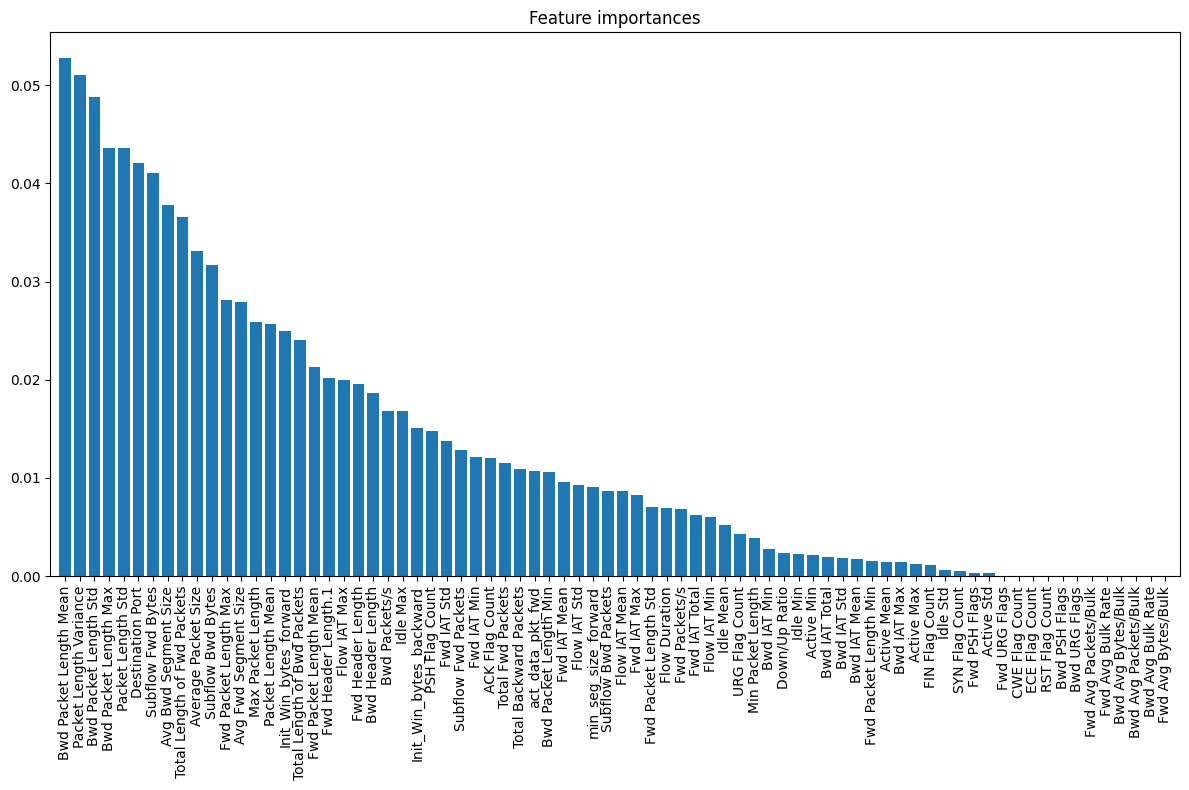

In [19]:
from joblib import dump, load

# Load the pre-trained Random Forest model
path_to_model = 'models/random_forest_model.pkl'
rf = load(path_to_model)

# Retrieve the feature importances from the loaded model
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a plot to visualize the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
# Since X_scaled is an array, use the columns of X before scaling for labels
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()  # Adjusts the plot padding
plt.savefig("Feature_importances_CICIDS2017_RFC.png")
plt.show()


Correlation

In [20]:
# Convert scaled features back to a DataFrame for easier manipulation
X_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate the correlation matrix
correlation_matrix = X_df.corr()

# Display the correlation matrix
print(correlation_matrix)


                             Destination Port  Flow Duration  \
Destination Port                     1.000000      -0.151047   
Flow Duration                       -0.151047       1.000000   
Total Fwd Packets                   -0.004227       0.020832   
Total Backward Packets              -0.003949       0.019689   
Total Length of Fwd Packets          0.011966       0.067221   
...                                       ...            ...   
Active Min                          -0.019274       0.111442   
Idle Mean                           -0.112265       0.767754   
Idle Std                             0.011627       0.240434   
Idle Max                            -0.107633       0.778666   
Idle Min                            -0.114494       0.738525   

                             Total Fwd Packets  Total Backward Packets  \
Destination Port                     -0.004227               -0.003949   
Flow Duration                         0.020832                0.019689   
Total Fwd

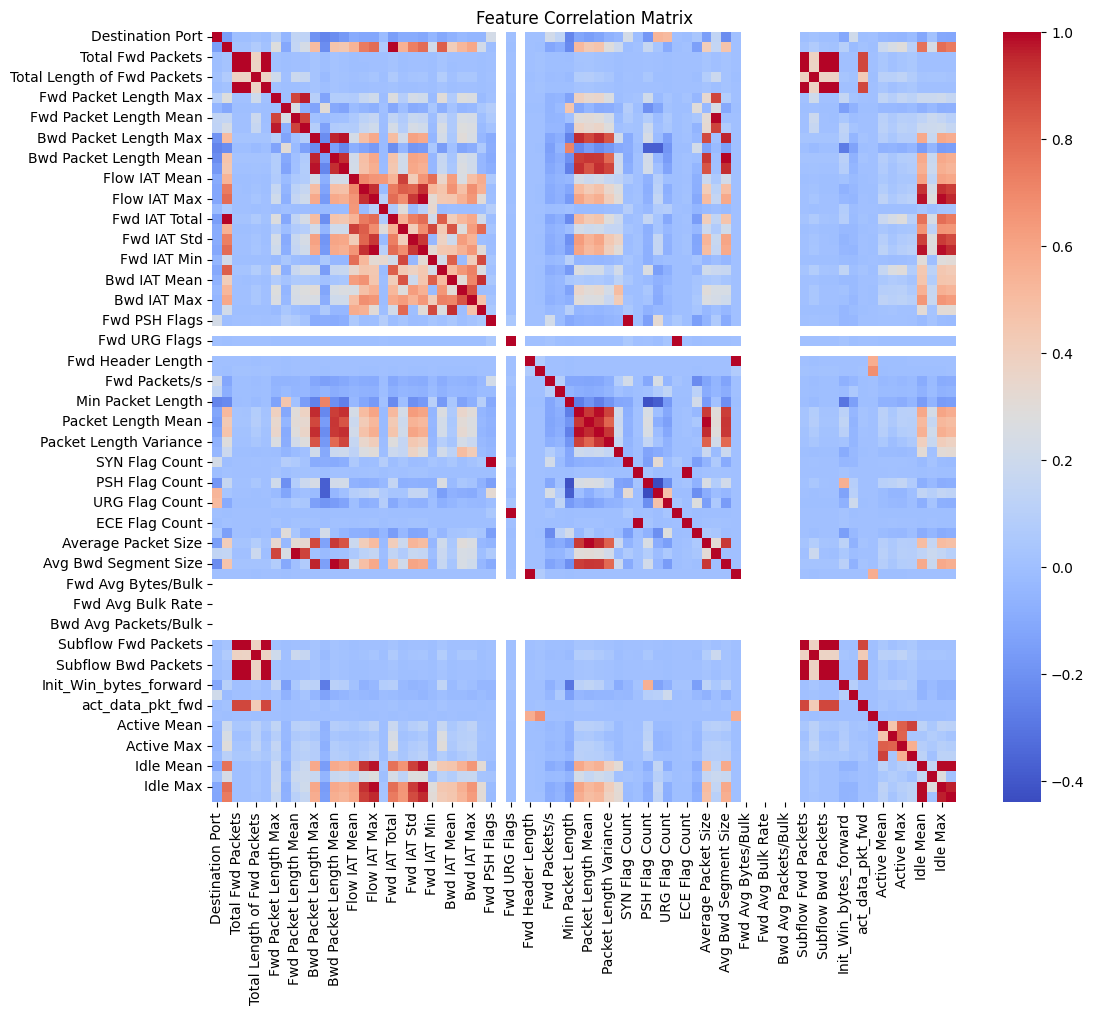

In [21]:
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [22]:
# Define a threshold to identify highly correlated features
threshold = 0.85

# Create an empty set to hold the names of features to remove
features_to_remove = set()

# Iterate over the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            # Get the name of one of the highly correlated features
            colname = correlation_matrix.columns[i]
            # Add the column name to the set
            features_to_remove.add(colname)

# Print the features to be removed
print(features_to_remove)

# Remove the features from the DataFrame
X_df_reduced = X_df.drop(columns=features_to_remove)

# Display the shape of the DataFrame before and after
print("Original feature count:", X_df.shape[1])
print("Reduced feature count:", X_df_reduced.shape[1])


{'Fwd IAT Std', 'SYN Flag Count', 'Fwd IAT Min', 'act_data_pkt_fwd', 'Idle Mean', 'Average Packet Size', 'Avg Bwd Segment Size', 'Subflow Bwd Packets', 'Idle Min', 'Bwd IAT Min', 'Subflow Fwd Bytes', 'Active Min', 'Packet Length Variance', 'Max Packet Length', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Max', 'Bwd IAT Max', 'ECE Flag Count', 'Avg Fwd Segment Size', 'Subflow Fwd Packets', 'Total Backward Packets', 'Idle Max', 'Packet Length Std', 'Packet Length Mean', 'Fwd Header Length.1', 'Bwd Packet Length Mean', 'Fwd IAT Total', 'Subflow Bwd Bytes', 'Fwd IAT Mean', 'CWE Flag Count', 'Total Length of Bwd Packets', 'Fwd Packet Length Mean', 'Fwd Packet Length Std'}
Original feature count: 76
Reduced feature count: 42


In [23]:


#   ~~~DONT DROP ANY ROWS AFTER THIS BLOCK ~~~



# Dataset for binary classifier
# Convert labels: 0 remains 0 (benign), all others become 1 (attack)
y_binary = np.where(y_encoded > 0, 1, 0)

# Multiclass Classifier Dataset (only for attack types)
# Filter out benign samples
attack_indices = y_encoded > 0
#X_attacks = X_scaled[attack_indices] changed after feature selection
X_attacks = X_df_reduced[attack_indices]
y_attacks = y_encoded[attack_indices]

# Check distribution of attack classes
print(np.unique(y_attacks, return_counts=True))
print("\n",X_attacks.shape)


(array([1, 2, 3, 4, 5, 6, 7]), array([128027,  10293, 231073,   5796,   7938, 158930,   5897],
      dtype=int64))

 (547954, 42)


In [24]:
import pickle
with open('processed/processed_final_dataset.pkl', 'wb') as f:
    pickle.dump({'features': X_df_reduced, 'labels': y_encoded}, f)

In [15]:
import pickle

# Saving binary dataset
with open('processed/binary_dataset.pkl', 'wb') as f:
    pickle.dump({'features': X_df_reduced, 'labels': y_binary}, f)

# Saving multiclass dataset
with open('processed/attacks_dataset.pkl', 'wb') as f:
    pickle.dump({'features': X_attacks, 'labels': y_attacks}, f)


In [15]:
import sklearn
print(sklearn.__version__)

1.2.2


Run smot for binry dataset after this

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
